1. No layers, just:

* Initialize LSTM Params
* Write LSTM Model - sticking close to working example
* Write LSTM Layer - sticking close to working example - use `t` to index time and use "forward-backward" functions.
* Write LSTM node
* Write "sample" fuction

## Activations

In [103]:
import matplotlib.pyplot as plt
from IPython import display
plt.style.use('seaborn-white')
%matplotlib inline

from copy import deepcopy

In [104]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def dsigmoid(y):
    return y * (1 - y)


def tanh(x):
    return np.tanh(x)


def dtanh(y):
    return 1 - y * y


def softmax(x):
    return np.exp(x) / np.sum(np.exp(x)) #softmax

In [105]:
class LSTM_Param:
    def __init__(self, value):
        self.value = value
        self.deriv = np.zeros_like(value) #derivative
        self.momentum = np.zeros_like(value) #momentum for AdaGrad
        
    def clear_gradient(self):
        self.deriv = np.zeros_like(self.value) #derivative
        
    def clip_gradient(self):
        self.deriv = np.clip(self.deriv, -1, 1, out=self.deriv)
        
    def update(self, learning_rate):
        self.momentum += self.deriv * self.deriv # Calculate sum of gradients
        self.value += -(learning_rate * self.deriv / np.sqrt(self.momentum + 1e-8))
        
    def update_sgd(self, learning_rate):
        self.value -= learning_rate * self.deriv

In [106]:
class LSTM_Params:
    
    def __init__(self, hidden_size, vocab_size):
        self.stack_size = hidden_size + vocab_size
        
        self.W_f = LSTM_Param(np.random.normal(size=(hidden_size, self.stack_size), loc=0, scale=0.1))
        self.W_i = LSTM_Param(np.random.normal(size=(hidden_size, self.stack_size), loc=0, scale=0.1))
        self.W_c = LSTM_Param(np.random.normal(size=(hidden_size, self.stack_size), loc=0, scale=0.1))
        self.W_o = LSTM_Param(np.random.normal(size=(hidden_size, self.stack_size), loc=0, scale=0.1))
        self.W_v = LSTM_Param(np.random.normal(size=(vocab_size, hidden_size), loc=0, scale=0.1))
        
        self.B_f = LSTM_Param(np.zeros((hidden_size, 1)))
        self.B_i = LSTM_Param(np.zeros((hidden_size, 1)))
        self.B_c = LSTM_Param(np.zeros((hidden_size, 1)))
        self.B_o = LSTM_Param(np.zeros((hidden_size, 1)))
        self.B_v = LSTM_Param(np.zeros((vocab_size, 1)))

        
    def all_params(self):
        return [self.W_f, self.W_i, self.W_c, self.W_o, self.W_v, 
                self.B_f, self.B_i, self.B_c, self.B_o, self.B_v]
        
    def clear_gradients(self):
        for param in self.all_params():
            param.clear_gradient()
        
    def clip_gradients(self):
        for param in self.all_params():
            param.clip_gradient()       
       
    def update_params(self, learning_rate, method="ada"):
        for param in self.all_params():
            if method == "ada":
                param.update(learning_rate)  
            elif method == "sgd":
                param.update_sgd(learning_rate)

In [107]:
class LSTM_Model:
    
    def __init__(self, vocab_size, hidden_size, learning_rate):
        self.start_H = np.zeros((hidden_size, 1))
        self.start_C = np.zeros((hidden_size, 1))
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        self.learning_rate = learning_rate
        self.params = LSTM_Params(hidden_size, vocab_size)
        
    def forward_backward(self, inputs, targets):

        # To store the values for each time step
        x_s, z_s, f_s, i_s,  = {}, {}, {}, {}
        C_bar_s, C_s, o_s, h_s = {}, {}, {}, {}
        v_s, y_s =  {}, {}

        # Values at t - 1
        h_s[-1] = np.copy(self.start_H)
        C_s[-1] = np.copy(self.start_C)

        loss = 0
        # Loop through time steps

        for t in range(len(inputs)):
            x_s[t] = np.zeros((self.vocab_size, 1))
            x_s[t][inputs[t]] = 1 # Input character

            (z_s[t], f_s[t], i_s[t],
            C_bar_s[t], C_s[t], o_s[t], h_s[t],
            v_s[t], y_s[t]) = \
                self.forward(x_s[t], h_s[t - 1], C_s[t - 1]) # Forward pass

            # The 0 included only because y_s is 2 dimensional (since we are using batch size 1)

            loss += -np.log(y_s[t][targets[t], 0]) # Loss for at t

        self.params.clear_gradients()

        dh_next = np.zeros_like(h_s[0]) #dh from the next character
        dC_next = np.zeros_like(C_s[0]) #dc from the next character

        for t in reversed(range(len(inputs))):
            # Backward pass
            dh_next, dC_next = \
                self.backward(target = targets[t], dh_next = dh_next,
                         dC_next = dC_next, C_prev = C_s[t-1],
                         z = z_s[t], f = f_s[t], i = i_s[t], C_bar = C_bar_s[t],
                         C = C_s[t], o = o_s[t], h = h_s[t], v = v_s[t],
                         y = y_s[t])

        self.params.clip_gradients()

        self.start_H = h_s[len(inputs) - 1]
        self.start_C = C_s[len(inputs) - 1]
        
        return loss
    
    def forward(self, x, h_prev, C_prev):
        assert x.shape == (self.vocab_size, 1)
        assert h_prev.shape == (self.hidden_size, 1)
        assert C_prev.shape == (self.hidden_size, 1)

        z = np.row_stack((h_prev, x))
        f = sigmoid(np.dot(self.params.W_f.value, z) + self.params.B_f.value)
        i = sigmoid(np.dot(self.params.W_i.value, z) + self.params.B_i.value)
        C_bar = tanh(np.dot(self.params.W_c.value, z) + self.params.B_c.value)

        C = f * C_prev + i * C_bar
        o = sigmoid(np.dot(self.params.W_o.value, z) + self.params.B_o.value)
        h = o * tanh(C)

        v = np.dot(self.params.W_v.value, h) + self.params.B_v.value
        y = np.exp(v) / np.sum(np.exp(v)) #softmax

        return z, f, i, C_bar, C, o, h, v, y


    def backward(self, target, dh_next, dC_next, C_prev,
                 z, f, i, C_bar, C, o, h, v, y):

        assert z.shape == (self.vocab_size + self.hidden_size, 1)
        assert v.shape == (self.vocab_size, 1)
        assert y.shape == (self.vocab_size, 1)

        for param in [dh_next, dC_next, C_prev, f, i, C_bar, C, o, h]:
            assert param.shape == (self.hidden_size, 1)

        dv = np.copy(y)
        dv[target] -= 1

        self.params.W_v.deriv += np.dot(dv, h.T)
        self.params.B_v.deriv += dv

        dh = np.dot(self.params.W_v.value.T, dv)        
        dh += dh_next
        do = dh * tanh(C)
        do = dsigmoid(o) * do
        self.params.W_o.deriv += np.dot(do, z.T)
        self.params.B_o.deriv += do

        dC = np.copy(dC_next)
        dC += dh * o * dtanh(tanh(C))
        dC_bar = dC * i
        dC_bar = dtanh(C_bar) * dC_bar
        self.params.W_c.deriv += np.dot(dC_bar, z.T)
        self.params.B_c.deriv += dC_bar

        di = dC * C_bar
        di = dsigmoid(i) * di
        self.params.W_i.deriv += np.dot(di, z.T)
        self.params.B_i.deriv += di

        df = dC * C_prev
        df = dsigmoid(f) * df
        self.params.W_f.deriv += np.dot(df, z.T)
        self.params.B_f.deriv += df

        dz = (np.dot(self.params.W_f.value.T, df)
             + np.dot(self.params.W_i.value.T, di)
             + np.dot(self.params.W_c.value.T, dC_bar)
             + np.dot(self.params.W_o.value.T, do))
        dh_prev = dz[:self.hidden_size, :]
        dC_prev = f * dC

        return dh_prev, dC_prev

In [113]:
class Character_generator:
    def __init__(self, text_file, LSTM_Model, sequence_length):
        self.data = open(text_file, 'r').read()
        self.model = LSTM_Model
        self.chars = list(set(self.data))
        self.vocab_size = len(self.chars)
        self.char_to_idx = {ch:i for i,ch in enumerate(self.chars)}
        self.idx_to_char = {i:ch for i,ch in enumerate(self.chars)}
        self.iterations = 0
        self.start_pos = 0
        self.sequence_length = sequence_length
        self.smooth_loss = -np.log(1.0 / self.vocab_size) * self.sequence_length
    
    def _generate_inputs_targets(self, start_pos):
        inputs = ([self.char_to_idx[ch] 
                   for ch in self.data[start_pos: start_pos + self.sequence_length]])
        targets = ([self.char_to_idx[ch] 
                    for ch in self.data[start_pos + 1: start_pos + self.sequence_length + 1]])
        return inputs, targets


    def sample_output(self, input_char, sample_length):
        
        x = np.zeros((self.vocab_size, 1))
        x[input_char] = 1
        
        
        sample_model = deepcopy(self.model)
        
        indices = []
        for char in range(sample_length): 
            _, _, _, _, _, _, _, _, p = sample_model.forward(x, 
                                                             sample_model.start_H, 
                                                             sample_model.start_C)
            idx = np.random.choice(range(self.vocab_size), p=p.ravel())
            
            x = np.zeros((self.vocab_size, 1))
            x[idx] = 1.0
            indices.append(idx)
            
        txt = ''.join(self.idx_to_char[idx] for idx in indices)
        return txt
    
    
    def single_step(self):
   
        inputs, targets = self._generate_inputs_targets(self.start_pos)
        
        loss = self.model.forward_backward(inputs, targets)
            
        self.model.params.update_params(self.model.learning_rate)
        
        return loss


    def training_loop(self, num_iterations, ):
        
        plot_iter = np.zeros((0))
        plot_loss = np.zeros((0))
        
        num_iter = 0
        
        while num_iter < num_iterations:
            
            if self.start_pos + self.sequence_length > len(self.data):
                self.start_pos = 0
            
            loss = self.single_step()
            
            self.start_pos += self.sequence_length
                
            plot_iter = np.append(plot_iter, [num_iter])
            plot_loss = np.append(plot_loss, [loss])
            
            if num_iter % 100 == 0:
                plt.plot(plot_iter, plot_loss)
                display.clear_output(wait=True)
                plt.show()
                
                sample_text = self.sample_output(self.char_to_idx[self.data[self.start_pos]], 
                                                 200)
                print(sample_text)

            self.start_pos += self.sequence_length
            num_iter += 1
            
            

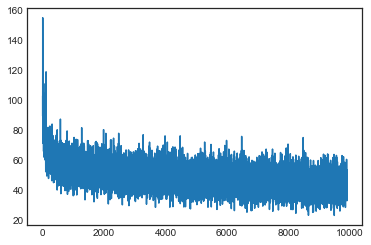

e! io la ite tir e, de, O: we Lrasiom is!; we ce oRareaio uce o-

Bemay aisie n pe se fe aige he we ao. de slefe; iobubege ie isedatede
Beware ace tiaile a-S: ob ou obine ie e gay qul taif hfu ion fid


In [114]:
mod = LSTM_Model(vocab_size=62, hidden_size=100, learning_rate=0.1)
character_generator = Character_generator('input.txt', mod, sequence_length=25)
character_generator.training_loop(10000)

TODO: implement LSTM_Step using forward_backward from other code

# Old